In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import least_squares

from rdn.analysis import kruskal_dunn

In [ ]:
def preprocess_dataframe(df):

    # Define the logarithms of the quantities so we can work with gaussians
    df['log-syp-avg'] = df['syp-avg'].map(lambda x: np.log(x))
    df['log-syp-sem'] = df['syp-sem'] / df['syp-avg']

    df['log-x-avg'] = df['x-avg'].map(lambda x: np.log(x))
    df['log-x-sem'] = df['x-sem'] / df['x-avg']

    df['delta-counts'] = np.sqrt(df['counts'])


    df.dropna(inplace=True)

    return df


def gaussian_density(x, log_c, log_mu, log_sigma):
    return (
        np.exp(log_c)
        * np.exp(
            -(x-np.exp(log_mu))**2/(2*np.exp(log_sigma)**2)
        )
    )

def residual(p,X,Y,Yerr):
    return (gaussian_density(X,*p) - Y)/Yerr


def rrmse(y,pred, yerr=None):
    return np.sqrt(
        ((y-pred)**2).sum()/(y**2).sum()
    )

# Plotting
ebar_kwargs = dict(
    fmt='.',
    markerfacecolor='white',
    markeredgecolor='black',
    linewidth=1,
    ecolor='black',
    elinewidth=1,
    zorder=10,
    markersize=8,
)

In [3]:
proteins_dict = pd.read_excel(
    '../data/raw_data/protein-information-syp.xlsx',
    sheet_name=None,
    names=(
        'theoretical',
        'syp-avg',
        'syp-sem',
        'x-avg',
        'x-sem',
        'counts'
    )
)

for k in proteins_dict.keys():
    proteins_dict[k]['protein'] = k
    proteins_dict[k] = preprocess_dataframe(proteins_dict[k])

pdf = pd.concat([proteins_dict[k] for k in proteins_dict.keys()])

Attempt first ignoring the uncertainties on x
1. Fit the gaussians on the distributions of log-syp and log-x
2. Find if there is correlation between log-syp and log-x

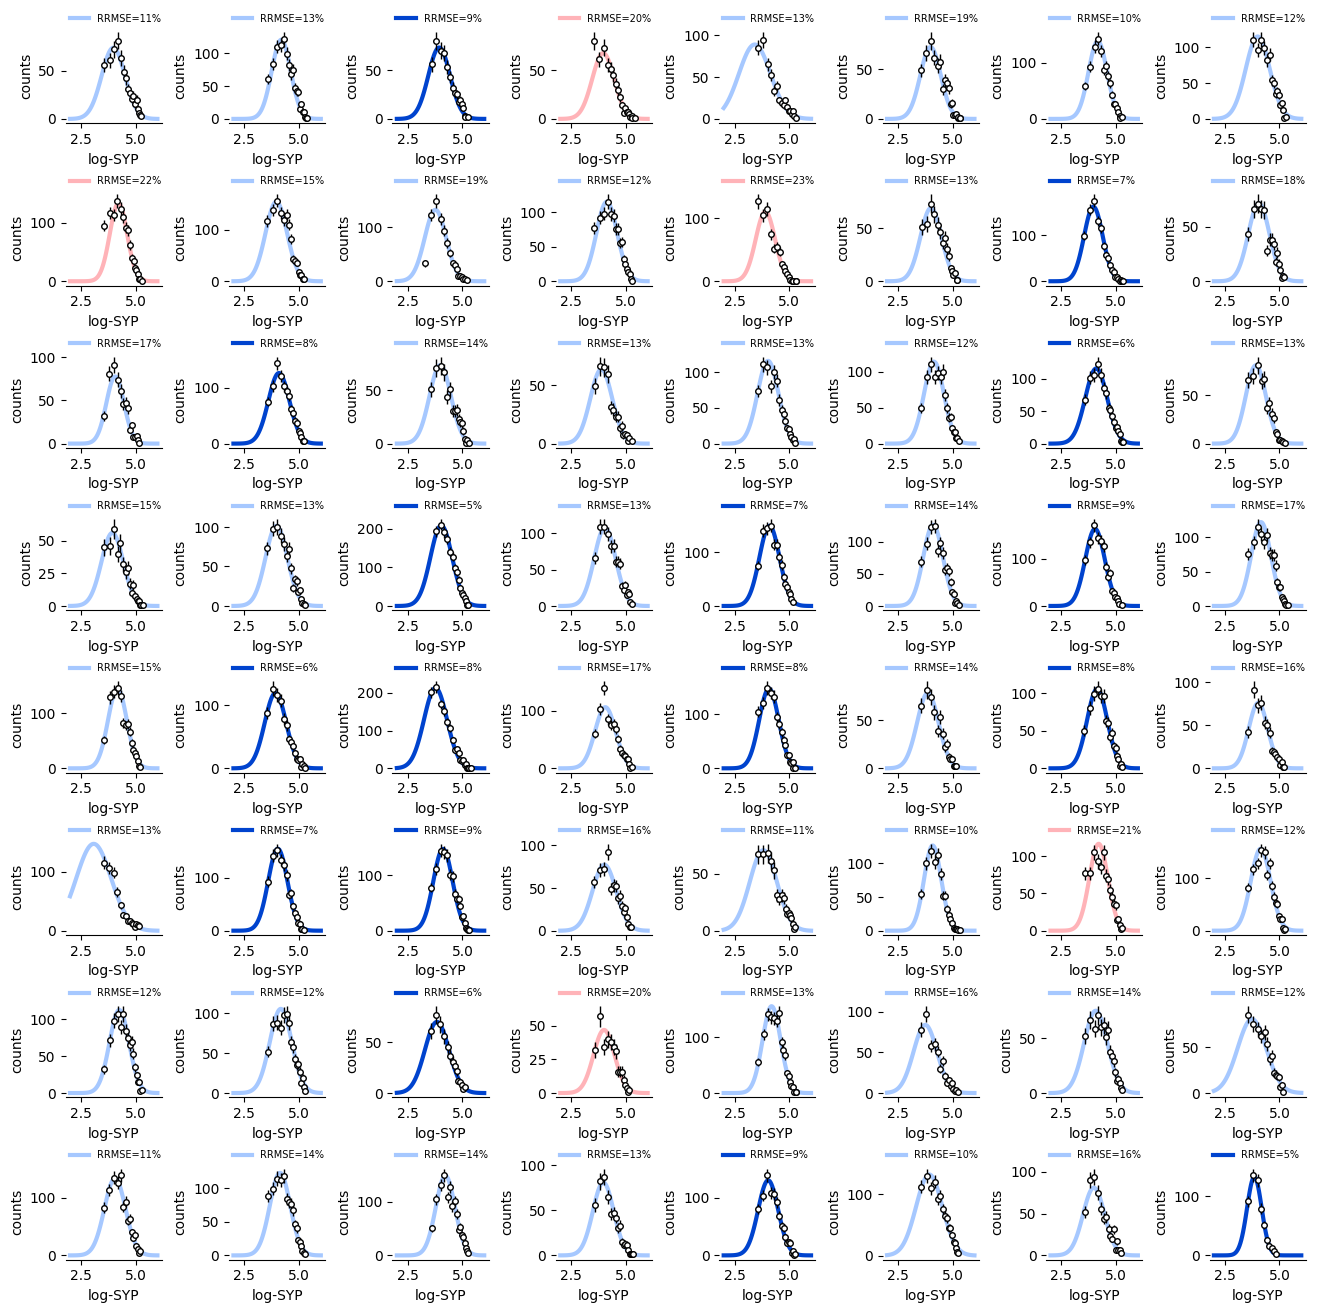

In [4]:
fig, axs = plt.subplots(8,8, figsize=(16,16))
fig.subplots_adjust(wspace=0.7, hspace=0.7)

syp_rrmses = []
res_syps = []

for ax, (k, df) in zip(axs.flatten(), proteins_dict.items()):

    df.dropna(inplace=True)
    df = preprocess_dataframe(df)

    res_syp = least_squares(
        residual,
        x0=(0.5,0.5,0.5,),
        args=(
            df['log-syp-avg'],
            df['counts'],
            df['delta-counts']
        ),
        loss='cauchy'
    )

    res_syps.append(res_syp)

    # Predictions
    syp_pred = gaussian_density(df['log-syp-avg'], *res_syp.x)
    syp_rrmse = rrmse(df['counts'],syp_pred, df['delta-counts'])
    syp_rrmses.append(syp_rrmse)

    if (syp_rrmse <= 0.1): line_color = '#0043ce'
    elif syp_rrmse <= 0.2: line_color = '#a6c8ff'
    elif syp_rrmse <= 0.3: line_color = '#ffb3b8'
    else: line_color = '#a2191f'

    # Plots
    X_plot = np.linspace(2,6,100)
    Y_plot_syp = gaussian_density(X_plot, *res_syp.x)


    ax.errorbar(
        x=df['log-syp-avg'],
        y=df['counts'],
        yerr=df['delta-counts'],
        **ebar_kwargs
    )
    ax.plot(X_plot, Y_plot_syp, c=line_color, linewidth=3, label=f'RRMSE={int(syp_rrmse*100)}%')

    ax.legend(frameon=False, fontsize=7, loc=(0,1))

    for k, v in ax.spines.items():
        if (k != 'bottom'): v.set_visible(False)

    # ax.set_yticks([])

    ax.set_xlabel(f'log-SYP')
    ax.set_ylabel('counts')

# plt.savefig('docs/figures/syp-log-distributions.svg', dpi=300)

0.38448891322536183


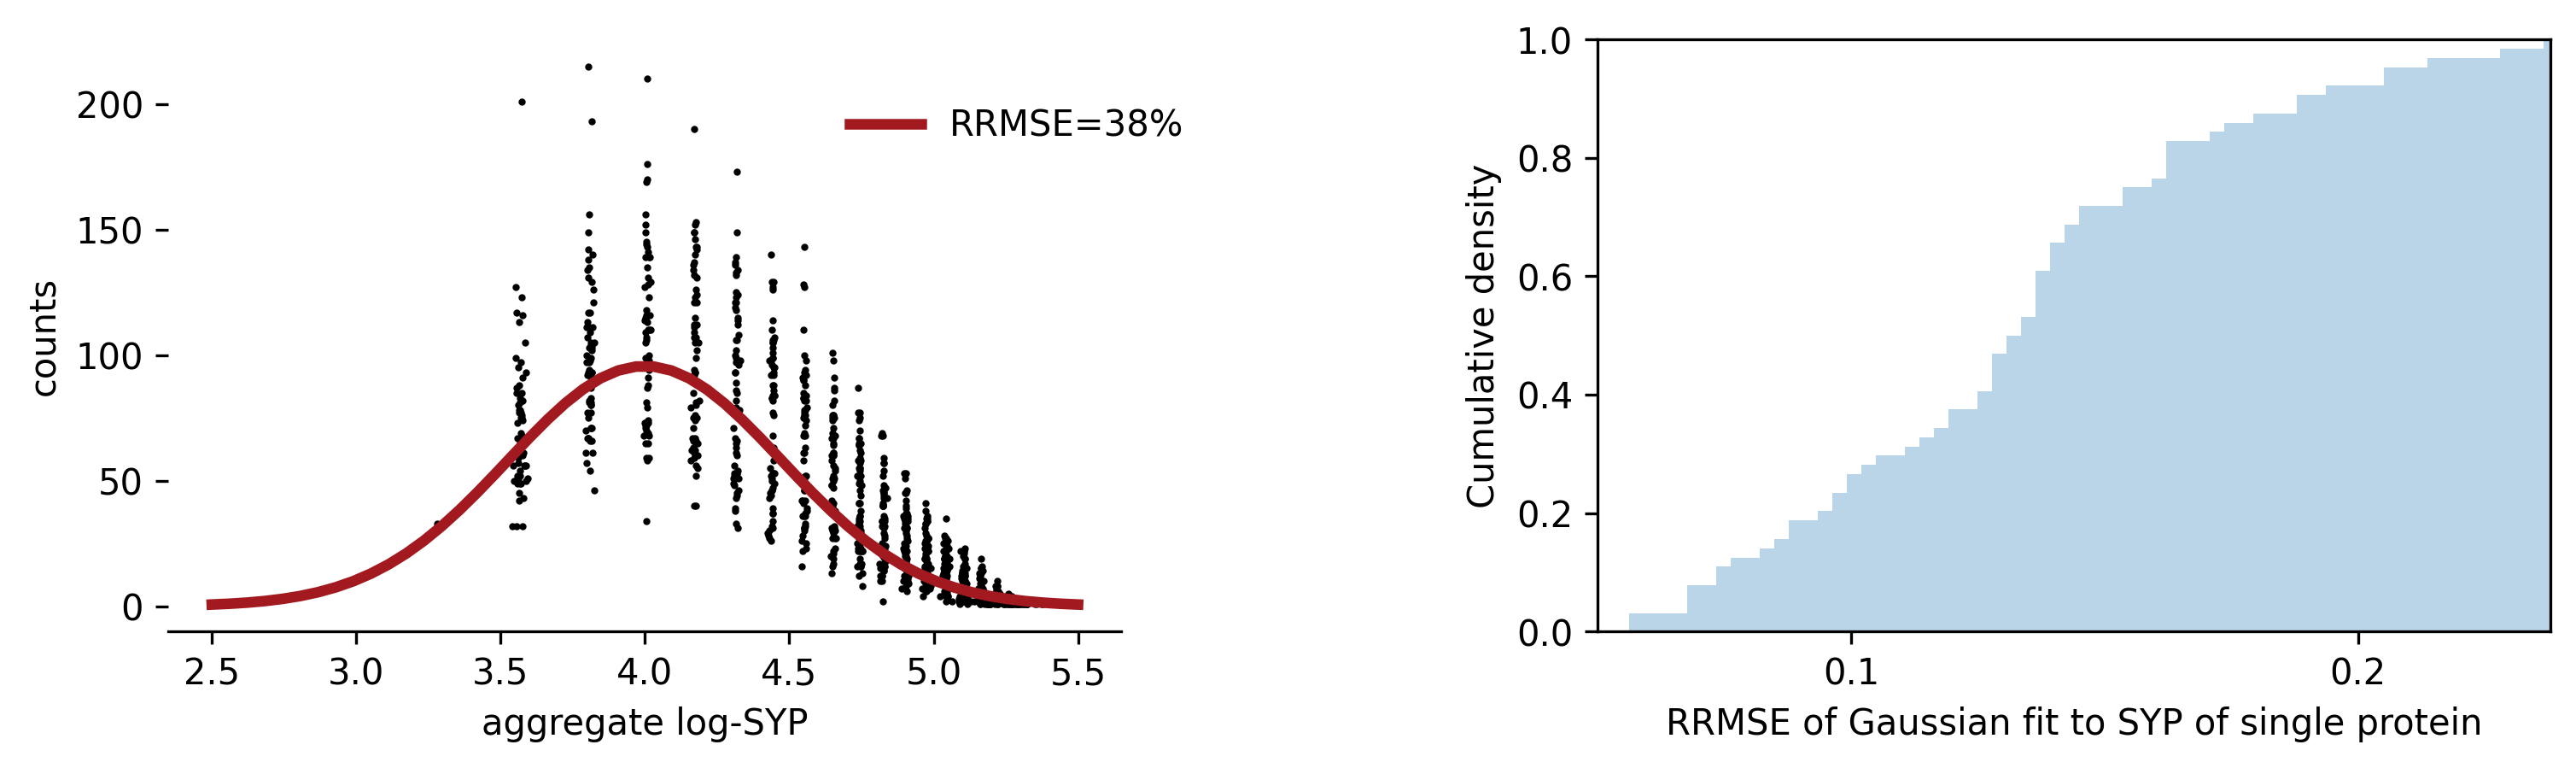

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,3), dpi=300)
fig.subplots_adjust(wspace=0.5)

cum_res = least_squares(residual, (1.,1.,1.,), args=(pdf['log-syp-avg'], pdf['counts'], pdf['delta-counts']))

plot_X = np.linspace(2.5, 5.5)
plot_Y = gaussian_density(plot_X, *cum_res.x)
pred_Y = gaussian_density(pdf['log-syp-avg'], *cum_res.x)

cum_rrmse = rrmse(pdf['counts'], pred_Y)
print(cum_rrmse)

ax = axs[0]
ax.scatter(pdf['log-syp-avg'], pdf['counts'], s=1, c='black')
ax.plot(plot_X, plot_Y, zorder=10, linewidth=3, c='#a2191f', label=f'RRMSE={int(cum_rrmse*100)}%')
ax.legend(frameon=False, loc=(0.7,0.8))
ax.set_xlabel('aggregate log-SYP')
ax.set_ylabel('counts')

for k, v in ax.spines.items():
    if (k != 'bottom'): v.set_visible(False)

ax = axs[1]
ax.hist(syp_rrmses, bins=64, cumulative=True, alpha=0.3, density=True);
ax.set_xlabel('RRMSE of Gaussian fit to SYP of single protein')
ax.set_ylabel('Cumulative density')
ax.set_xlim(0.05,0.238)
ax.set_ylim(0,1)
ax.set_xticks((0.1,0.2))


# plt.savefig('docs/figures/syp-diagnostics.svg', dpi=300)

In [6]:
syp_rrmses = np.array(syp_rrmses)
good_fraction = (syp_rrmses <= 0.2).sum()/len(syp_rrmses)
print(f'Acceptable fraction of RRMSEs: {good_fraction:.2f}')

Acceptable fraction of RRMSEs: 0.92


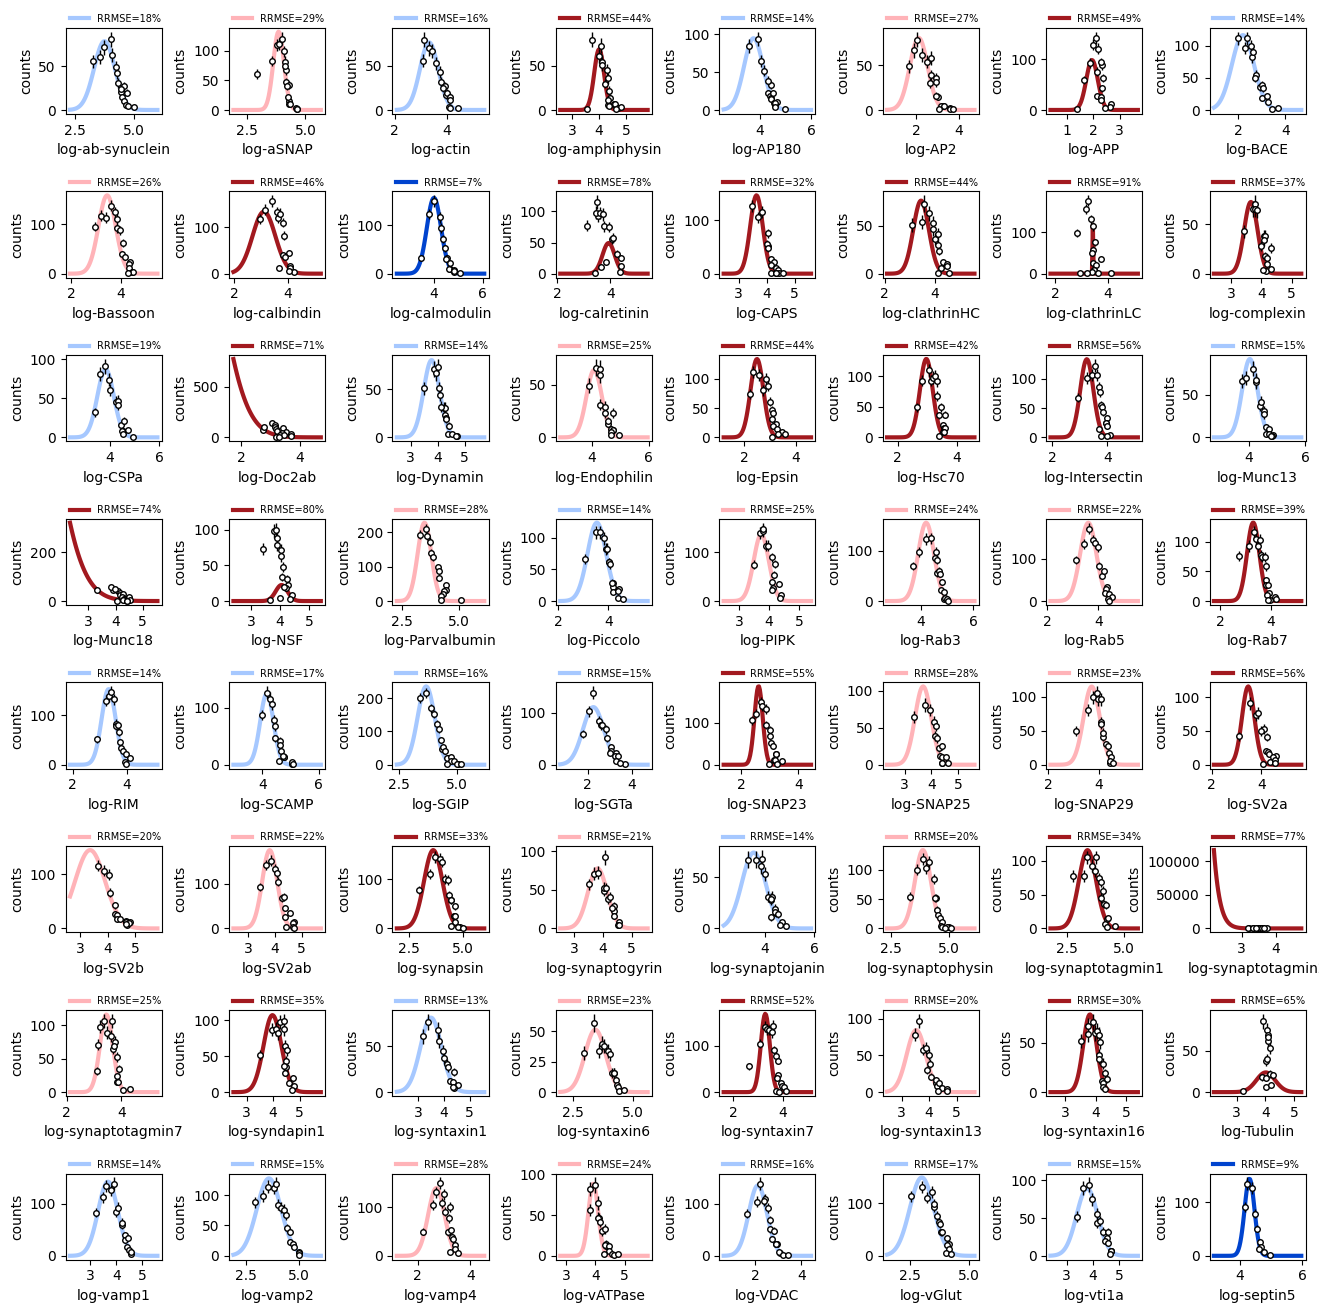

In [7]:
fig, axs = plt.subplots(8,8, figsize=(16,16))
fig.subplots_adjust(wspace=0.7, hspace=0.9)

x_rrmses = []
res_xs = []

for ax, (k, df) in zip(axs.flatten(), proteins_dict.items()):

    df.dropna(inplace=True)
    df = preprocess_dataframe(df)

    res_x = least_squares(
        residual,
        x0=(0.5,0.5,0.5,),
        args=(
            df['log-x-avg'],
            df['counts'],
            df['delta-counts']
        ),
        # loss='lorenz'
    )

    res_xs.append(res_x)

    # Predictions
    x_pred = gaussian_density(df['log-x-avg'], *res_x.x)
    x_rrmse = rrmse(df['counts'], x_pred, df['delta-counts'])
    x_rrmses.append(x_rrmse)

    if (x_rrmse <= 0.1): line_color = '#0043ce'
    elif x_rrmse <= 0.2: line_color = '#a6c8ff'
    elif x_rrmse <= 0.3: line_color = '#ffb3b8'
    else: line_color = '#a2191f'

    # Plots
    X_plot = np.linspace(df['log-x-avg'].min()-1,df['log-x-avg'].max()+1,100)
    Y_plot_x = gaussian_density(X_plot, *res_x.x)

    ax.errorbar(
        x=df['log-x-avg'],
        y=df['counts'],
        yerr=df['delta-counts'],
        **ebar_kwargs
    )
    ax.plot(X_plot, Y_plot_x, c=line_color, linewidth=3, label=f'RRMSE={int(x_rrmse*100)}%')

    ax.legend(frameon=False, fontsize=7, loc=(0,1))

    ax.set_xlabel(f'log-{k}')
    ax.set_ylabel('counts')

# plt.savefig('docs/figures/presyn-x-log-distributions', dpi=300)

In [8]:
x_rrmses = np.array(x_rrmses)
good_fraction = (x_rrmses <= 0.2).sum()/len(x_rrmses)
print(f'Acceptable fraction of RRMSEs: {good_fraction:.2f}')
print((x_rrmses <= 0.2).sum())

Acceptable fraction of RRMSEs: 0.33
21


Text(0, 0.5, 'Cumulative density')

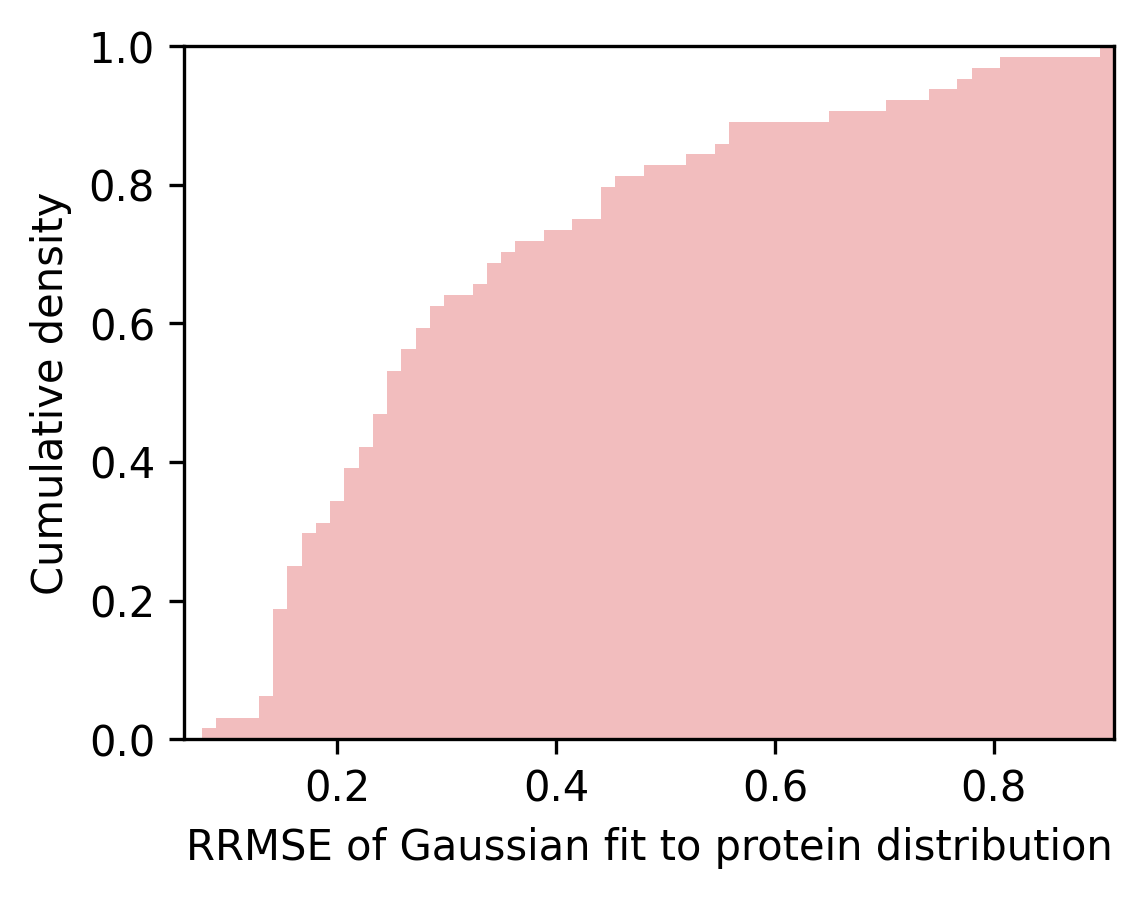

In [9]:
fig, ax = plt.subplots(1,1,figsize=(4,3), dpi=300)

ax.hist(x_rrmses, bins=64, cumulative=True, alpha=0.3, density=True, color='tab:red');

ax.set_xlim(0.06, 0.91)
ax.set_ylim(0,1)

ax.set_xlabel('RRMSE of Gaussian fit to protein distribution')
ax.set_ylabel('Cumulative density')


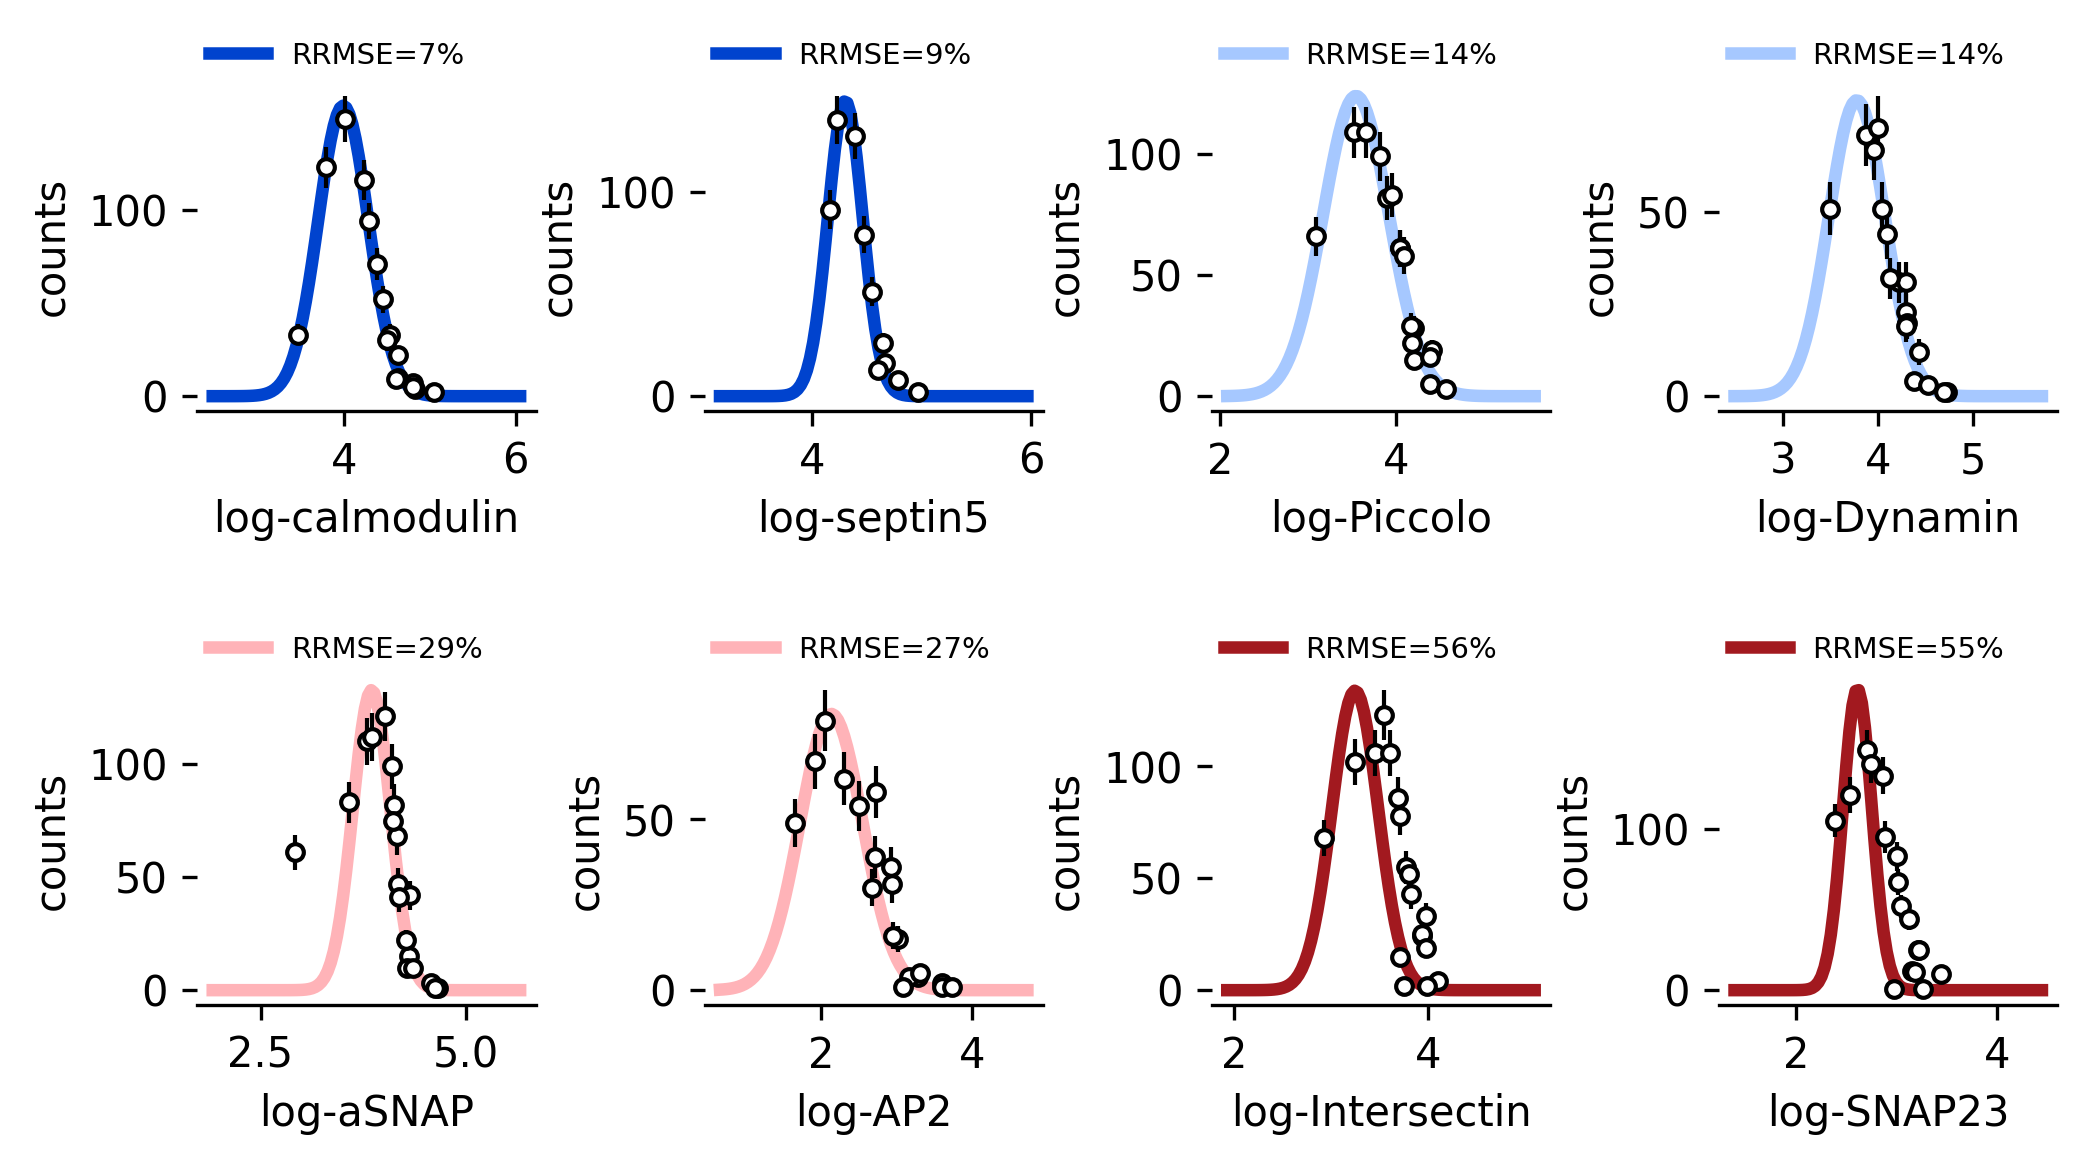

In [10]:
example_proteins = [
    'calmodulin',
    'septin5',
    'Piccolo',
    'Dynamin',
    'aSNAP',
    'AP2',
    'Intersectin',
    'SNAP23',
]

fig, axs = plt.subplots(2,4, figsize=(8,4), dpi=300)
fig.subplots_adjust(wspace=0.5, hspace=0.8)

for ax, k in zip(axs.flatten(), example_proteins):

    df = proteins_dict[k]
    df = preprocess_dataframe(df)

    res_x = least_squares(
        residual,
        x0=(0.5,0.5,0.5,),
        args=(
            df['log-x-avg'],
            df['counts'],
            df['delta-counts']
        ),
        # loss='lorenz'
    )

    res_xs.append(res_x)

    # Predictions
    x_pred = gaussian_density(df['log-x-avg'], *res_x.x)
    x_rrmse = rrmse(df['counts'], x_pred, df['delta-counts'])

    if (x_rrmse <= 0.1): line_color = '#0043ce'
    elif x_rrmse <= 0.2: line_color = '#a6c8ff'
    elif x_rrmse <= 0.3: line_color = '#ffb3b8'
    else: line_color = '#a2191f'

    # Plots
    X_plot = np.linspace(df['log-x-avg'].min()-1,df['log-x-avg'].max()+1,100)
    Y_plot_x = gaussian_density(X_plot, *res_x.x)

    ax.errorbar(
        x=df['log-x-avg'],
        y=df['counts'],
        yerr=df['delta-counts'],
        **ebar_kwargs
    )
    ax.plot(X_plot, Y_plot_x, c=line_color, linewidth=3, label=f'RRMSE={int(x_rrmse*100)}%')

    ax.legend(frameon=False, fontsize=7, loc=(0,1))


    ax.set_xlabel(f'log-{k}')

    for k,v in ax.spines.items():
        if k != 'bottom': v.set_visible(False)
    ax.set_ylabel('counts')

# plt.savefig('docs/figures/presyn-x-log-distributions', dpi=300)